In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/05-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/11-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/09-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/07-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/03-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/12-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/13-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/15-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/02-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/10-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-512x512/val/04-512x512-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

## Create Distribution Strategy ##

In [2]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on tpu", tpu.master())
    
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("Replicas", strategy.num_replicas_in_sync)

Running on tpu grpc://10.0.0.2:8470
Replicas 8


## Loading the Competition Data ##

In [3]:
from kaggle_datasets import KaggleDatasets
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

In [4]:
AUTO = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [512,512]
EPOCHS = 12
BATCH_SIZE = 16*strategy.num_replicas_in_sync
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

# Count images in each file

In [5]:
import math, re, os
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


In [6]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


# Define helper functions 

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32)/255.0 # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64) # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image,label # returns a dataset of (image, label) pairs
    
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string) # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset        
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image,idnum # returns a dataset of image(s)
    


In [8]:
def load_dataset(filenames, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False #disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset    

def data_augment(image,label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image,label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered= False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered= ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
    

# Datasets

In [9]:
ds_train = get_training_dataset()
ds_val = get_validation_dataset()
ds_test = get_test_dataset()

print("Training", ds_train)
print("Validation", ds_val)
print("Test", ds_test)



Training <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


In [10]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']

In [11]:
print("Number of classes: {}".format(len(CLASSES)))
print("First five classes, sorted alphabetically:")
for name in sorted(CLASSES)[:5]:
    print(name)
print("number of training images: {}".format(NUM_TRAINING_IMAGES))

Number of classes: 104
First five classes, sorted alphabetically:
alpine sea holly
anthurium
artichoke
azalea
balloon flower
number of training images: 12753


**Examine the shape of data**

In [12]:
print("Training data shapes")
for image,label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("training data label examples:", label.numpy())

Training data shapes
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
training data label examples: [ 45  68   4  73  13  96   4  76  67  68  73  75  86   9  37  69  74  48
  87   4   6  57  48 103  67  51  24  73 101  17   4  65  76  73  73  67
  30  92  48   0  25  67   8   8 102  83  94  48  76 103  53  45  30  67
  90 102  90  78 103  49  75   1  48  49  66  45   4   0  39  48   4  62
  13  47  13   4 103   4  53  95   4  77  79  11   0  72   4  49  62  18
  13  68   5  47 103   8 103  45  48  67  10  30  73  48  54  46  14  13
  83  46 103  13  75  49  74  14  72  48  44  80  96   0  72  21  47   4
  41  72]


In [13]:
print("Test data shapes")

for image,idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("test data IDs", idnum.numpy().astype('U'))

Test data shapes
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
test data IDs ['b87e16bc0' 'd8437a7f7' '981396649' '85c2ca274' 'f7019798c' 'b738a5ab0'
 '931b0b249' 'd35565c6c' '6fc119103' '7725cb554' 'f0727012b' '7b53e5791'
 'ce5af8fc3' 'aaab6a867' 'dd9cf65da' '13d3c108e' '34cc8d691' 'e93da9242'
 '46241640f' 'c77e635e6' '0befbdd9e' 'b05b5e5ed' '7484473e0' 'cffa6d1a4'
 'b811b25c9' 'bb15fd515' 'ce1019f58' 'cc0e98f9c' 'd83d3fbab' '1691d45e6'
 '026d4082b' '4fdd76274' 'a2fcedaf7' '62e32ec91' 'ed8c3c3f8' '7dc69b4eb'
 'b7c137651' 'c4d436848' '07ccfbc89' 'a0c7302d1' '1eba038ad' 'a7caedcb0'
 '92673a9aa' '8128b8af9' '8a8eefe09' 'ce6303fec' 'aa560af38' '9ed2586ca'
 'a64d32c6a' 'a10a0b280' '3d95467fe' 'b145790f2' 'e9a2109c0' '7593bf7d9'
 '09adc5faa' '1314201bc' '787578be9' '719a12da9' '4d178a6b4' '47c4e4fce'
 '903a3ee76' '94a7c5ed2' '3c5103dc0' '11db2e1d4' 'e2e81b2c4' 'cfdfb9028'
 '4e7bdb1cb' '8ccdebad5' '440daa96f' '953076db7' '32d710e55' '1a5d9c089'
 '364e07591' '5

# Dataset visualization

In [14]:
def display_one_flower(image,title,subplot, red = False, titlesize = 16):
    plt.subplot(*subplot)
    plt.axis("off")
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def batch_to_numpy_images_and_labels(data):
    images,labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object : #if binary string, these are image ids, and return none as label for test data
        numpy_labels = [None for _ in enumerate(numpy_images)]
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], true
    correct = (label ==correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO' , u"\u2192" if not correct else '',
                               CLASSES[correct_label] if not correct else ''), correct
                               
    
def display_batch_of_images(databatch, predictions = None):
    #data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    #auto-squaring, drop data that does not fit itno square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
    
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows,cols,1)
    
    if rows<cols:
        plt.figure(figsize = (FIGSIZE, FIGSIZE/cols*rows))
    else:
        plt.figure(figsize = (FIGSIZE/cols*rows, FIGSIZE))
        
    for i,(image,label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title='' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title,correct = title_from_label_and_target(predictions[i], label)
            
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3
        subplot = display_one_flower(image,title,subplot,not correct, titlesize = dynamic_titlesize)
    
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace = 0, hspace = 0)
    else:
        plt.subplots_adjust(wspace= SPACING, hspace = SPACING)
    plt.show()
    
    
    

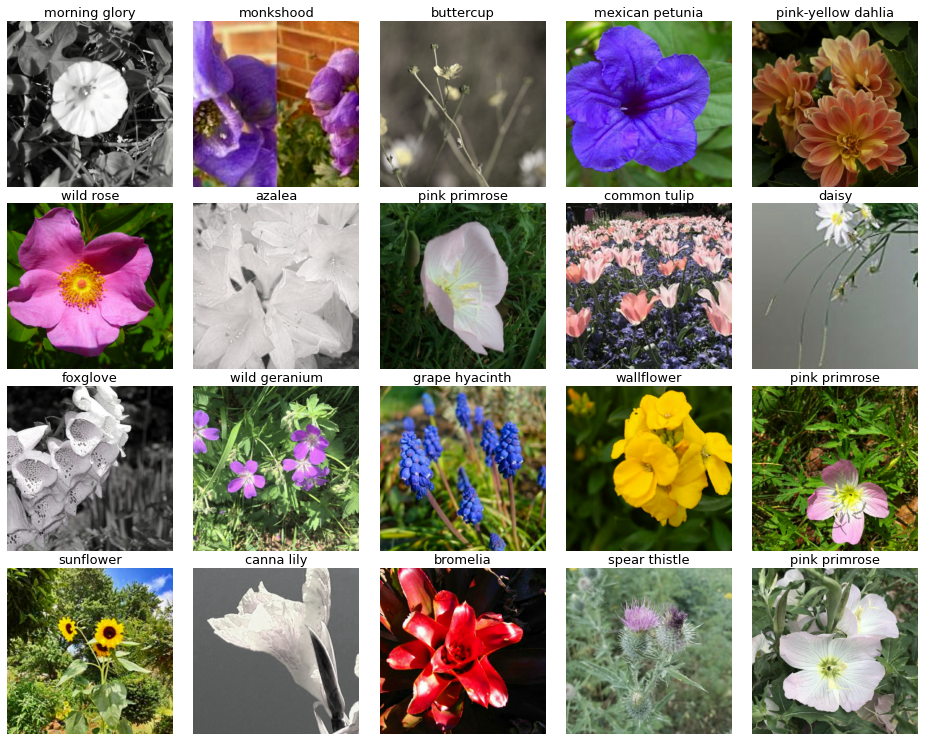

In [15]:
import matplotlib.pyplot as plt
one_batch = next(iter(ds_train.unbatch().batch(20)))
display_batch_of_images(one_batch)

**Define Learning rate Schedule **

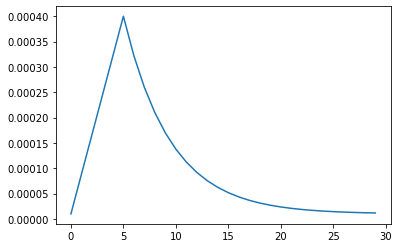

In [16]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 5 #5
LR_SUSTAIN_EPOCHS = 0 # 0
LR_EXP_DECAY = 0.80

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:  
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)   #   np.random.random_sample() * LR_START
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):  ####5-7lun
        lr = LR_MAX
    else:    
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
#    print('For epoch', epoch, 'setting lr to', lr)
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(30)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)

In [17]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = True)

# Define Model

In [18]:
!pip install -q efficientnet

In [19]:
import efficientnet.tfkeras as efficientnet
with strategy.scope():
    pretrained_model = efficientnet.EfficientNetB7(
        weights = 'noisy-student',
        include_top = False,
        input_shape = [*IMAGE_SIZE, 3]        
    )
    pretrained_model.trainable = True
    
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES),activation = 'softmax')
    ])
    
    model.compile(
        optimizer = 'adam',
        loss = 'sparse_categorical_crossentropy',
        metrics = ['sparse_categorical_accuracy'],
    )
model.summary()

258072576/258068648 [==============================] - 16s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


**TRAIN MODEL**

In [20]:
BATCH_SIZE = 16*strategy.num_replicas_in_sync
EPOCHS = 11
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES//BATCH_SIZE

history = model.fit(
    ds_train, 
    validation_data = ds_val,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    callbacks = [lr_callback, early_stop]
)



Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/11
99/99 [==============================] - 139s 1s/step - loss: 4.5862 - sparse_categorical_accuracy: 0.0456 - val_loss: 4.6004 - val_sparse_categorical_accuracy: 0.0288 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/11
99/99 [==============================] - 111s 1s/step - loss: 3.4540 - sparse_categorical_accuracy: 0.2956 - val_loss: 2.2540 - val_sparse_categorical_accuracy: 0.5197 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/11
99/99 [==============================] - 112s 1s/step - loss: 1.4874 - sparse_categorical_accuracy: 0.6595 - val_loss: 0.6255 - val_sparse_categorical_accuracy: 0.8491 - lr: 1.6600e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
Epoch 4/11
99/99 [==============================] - 111s 1s/step - loss: 0.6779 - sparse_categorical_accuracy: 0.8355 - val_loss

**EXAMINE TRAINING CURVE**

In [21]:
def display_training_curves(training, validation, title,subplot):
    if subplot%10 == 1:
        plt.subplots(figsize = (10,10), facecolor = '#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train ', 'valid'])

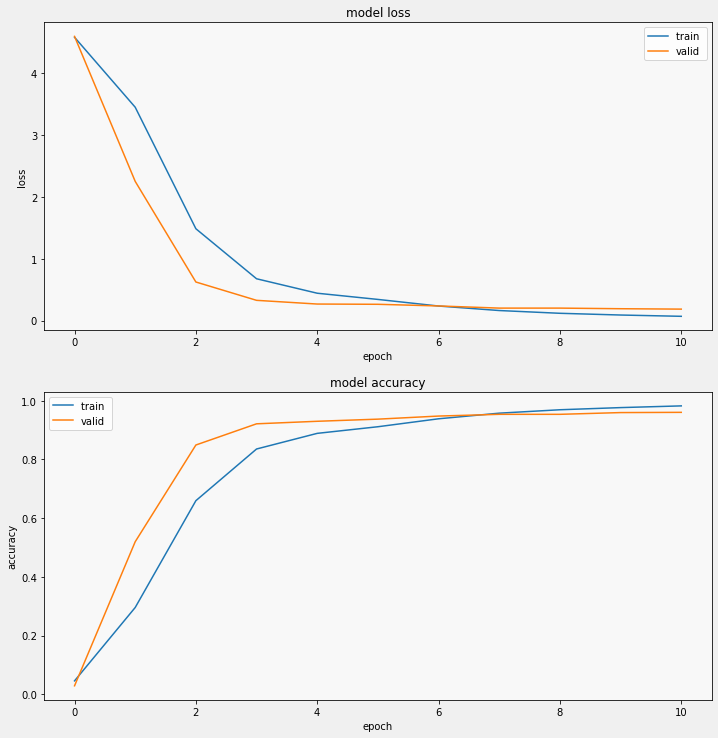

In [22]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)

display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

**Validation: **
Create Confusion Matrix


In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
cmdataset = get_validation_dataset(ordered = True)
images_ds = cmdataset.map(lambda image,label:image)
labels_ds = cmdataset.map(lambda image,label:label ).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilites = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilites, axis = -1)
labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels = labels,
)
cmat = (cmat.T/cmat.sum(axis=1)).T

In [24]:
def display_confusion_matrix(cmat,score,precision,recall):
    plt.figure(figsize = (15,15))
    ax= plt.gca()
    ax.matshow(cmat, cmap = 'Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict= {'fontsize':7})
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "left", rotation_mode = "anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict= {'fontsize':7})
    plt.setp(ax.get_yticklabels(), rotation = 45, ha = "left", rotation_mode = "anchor")
    titlestring=""
    if score is not None:
        titlestring += 'f1 = {:.3f}'.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f}'.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f}'.format(recall)
    if len(titlestring)>0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    

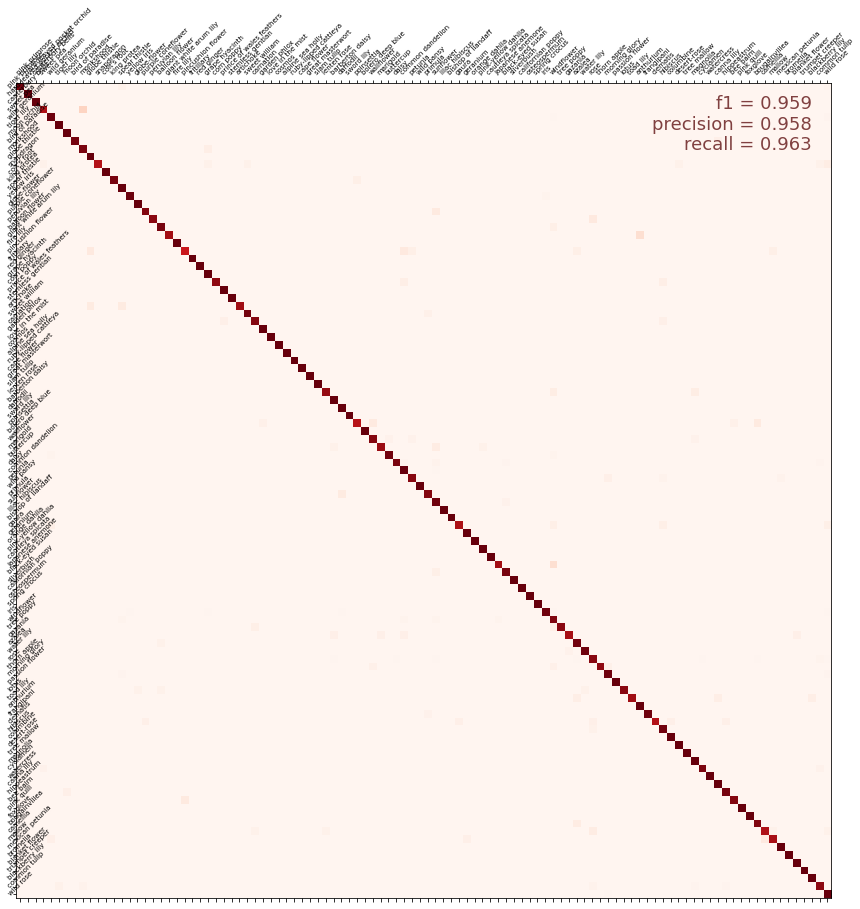

In [25]:
score  = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels = labels,
    average= 'macro',
)

precision = precision_score(
	cm_correct_labels,
    cm_predictions,
    labels = labels,
    average = 'macro',
)

recall = recall_score(
	cm_correct_labels,
    cm_predictions,
    labels = labels,
    average = 'macro',
)
display_confusion_matrix(cmat,score,precision,recall)

**Look at examples from the dataset, with true and predicted classes.**

In [26]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)


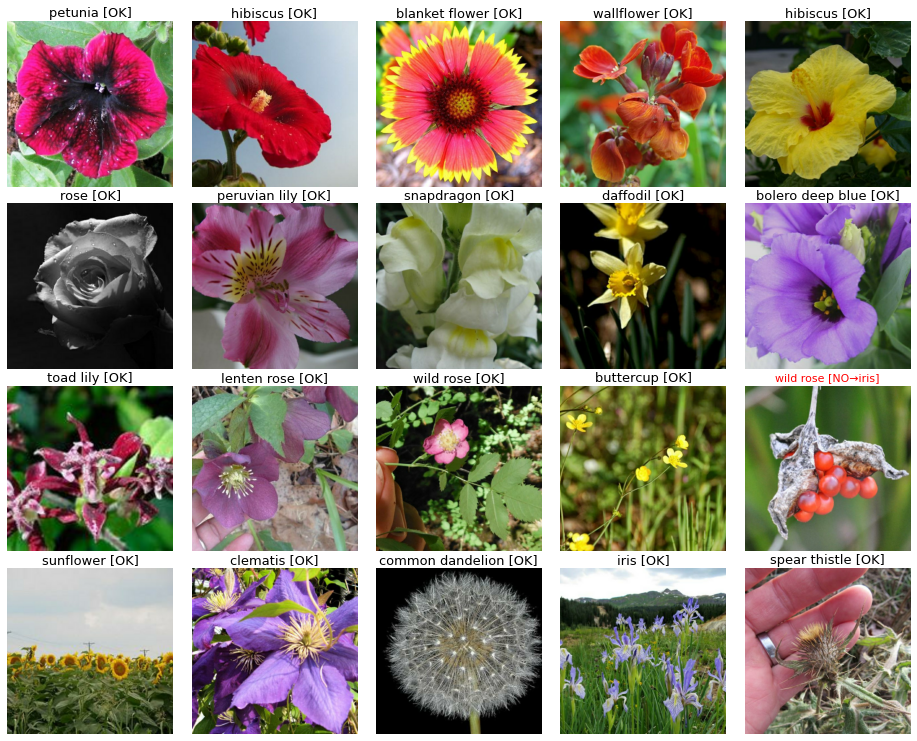

In [27]:
images,labels = next(batch)
probabilites = model.predict(images)
predictions = np.argmax(probabilites, axis = -1)
display_batch_of_images((images,labels), predictions)

**Test Predictions :
Create predictions to submit to the competition.**

In [28]:
test_ds = get_test_dataset(ordered = True)
print("Computing predictions for test set")
test_images_ds = test_ds.map(lambda image,idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis = -1)
print(predictions)


Computing predictions for test set
[ 67  28  83 ... 103 102  62]


In [29]:
print('Generating submision file')
test_ids_ds = test_ds.map(lambda image,idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

np.savetxt(
    "submission.csv",
    np.rec.fromarrays([test_ids, predictions]),
    fmt = ['%s', '%d'],
    delimiter = ',',
    header = 'id,label',
    comments = '',
    
)
!head submission.csv

Generating submision file
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,70
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82
